In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage import io
import utils_xy
from torchvision import transforms, utils
import numpy as np
from PIL import Image
from random import randint
import time

In [2]:
gpu_id = 1
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

device = torch.device('cuda')
print (device)

cuda


### I. Load the datasets

In [3]:
img_dir = '/home/xiaoyu/BMMC/BMMCdata'
mask_dir = '/home/xiaoyu/BMMC/BMMCmasks'

img_list = sorted(os.listdir(img_dir))
mask_list = sorted(os.listdir(mask_dir))

print("Training images numbers: "+str(len(img_list)))
print("Training mask Images numbers:"+str(len(mask_list)))

Training images numbers: 43
Training mask Images numbers:43


### Image and mask size observation
uint8	Unsigned integer (0 to 255)  
uint16	Unsigned integer (0 to 65535)

In [4]:
# Pick a random example
index = randint(0,42)
image_str = img_list[index]
mask_str = mask_list[index]

image_arr = io.imread(os.path.join(img_dir, image_str))
mask_arr = io.imread(os.path.join(mask_dir, mask_str))
print('Image array data type: ', image_arr.dtype)
print('\nMask array data type: ', mask_arr.dtype)

# convert the image data range from [0, 65535] to range [0,255]
image_arr = image_arr.astype(np.uint8)
print('\nImage array data type: ',image_arr.dtype)

# make 2 tensors from the numpy array for image and mask respectively
image_tensor = torch.from_numpy(image_arr)
mask_tensor = torch.from_numpy(mask_arr)

# observe the data size of the image and mask
print('\nImage data size: ', image_tensor.size())
print('\nMask data size:', mask_tensor.size())

Image array data type:  uint16

Mask array data type:  uint8

Image array data type:  uint8

Image data size:  torch.Size([1024, 1024, 3])

Mask data size: torch.Size([1024, 1024])


### Define a funciton for the visualization

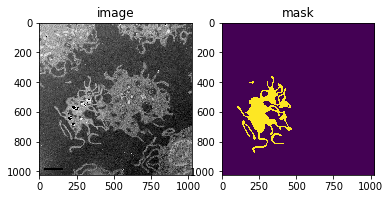

In [5]:
def show_mask(image, mask):
    """
    Show image and mask
    Args:
        image(numpyarray): The training image
        semantic(numpyarray): The training image semantic segmentation
    """    
    plt.subplot(1,2,1)
    plt.title('image')
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.title('mask')
    plt.imshow(mask)
    plt.show()
    
# test the function
show_mask(image_arr, mask_arr )

#### The input image is size 1024x1024x3, and the mask size is 1024x1024
### Find the unique color in mask
The unique color in mask is 85, 170, 255, so we can consider there are 3 classes in mask, for all 85 values, we consider it to be class 0, value 170 as class 1 and value 255 as class 2

In [6]:
colors = torch.tensor([])
for i in range(len(img_list)):
    img_arr = io.imread(os.path.join(img_dir, img_list[i]))
    img_tensor = torch.from_numpy(np.uint8(img_arr))
    img_tensor = img_tensor.permute(2,0,1)
    
    mask_str = mask_list[i]
    mask_arr = io.imread(os.path.join(mask_dir, mask_str))
    mask_tensor = torch.from_numpy(mask_arr)
    unique_color = torch.unique(mask_tensor).type(torch.FloatTensor)
    colors = torch.cat((colors,unique_color))
colors = torch.unique(colors)
print(colors)
print(colors.dtype)

tensor([ 85., 170., 255.])
torch.float32


### Test the mapping

In [7]:
b = torch.Tensor([[0.3333,0.6667,0.3333,1.0000],[0.3333,0.6667,0.3333,1.0000]])
torch.round(b / 0.3).byte()-1

tensor([[0, 1, 0, 2],
        [0, 1, 0, 2]], dtype=torch.uint8)

### Define the training set class
In the TrainDataset, the image is a tensor whose size is C x H x W, the mask is a tensor whose size is H x W.
The transform attribute is only applied to image tensor. The preprocess of the mask image is done inside this TrainDataset, which means the resize to 128 x 128

In [8]:
class TrainDataset(Dataset):
    """Training dataset with mask image mapping to classes"""
    def __init__(self, img_dir, mask_dir, transform=None):
        """
        Args:
            train_dir (string): Directory with training images
            transform (callable): Optional transform to be applied on a sample
            semantic_dir (string): Directory with semantic segmentation training image
        """
        self.img_dir = img_dir
        self.transform = transform
        self.mask_dir = mask_dir
        
        
    def __len__(self):
        img_list = os.listdir(self.img_dir)
        return len(img_list)
    
    def __getitem__(self, idx):
        img_list = sorted(os.listdir(img_dir))
        mask_list = sorted(os.listdir(mask_dir))
        
        img_str = img_list[idx]
        img_arr = io.imread(os.path.join(img_dir, img_str))
        img_tensor = torch.from_numpy(np.uint8(img_arr))
        img_tensor = img_tensor.permute(2,0,1)
        
        mask_str = mask_list[idx]
        mask_arr = io.imread(os.path.join(mask_dir, mask_str))
        mask_tensor = torch.from_numpy(mask_arr)
        
        # after the compose, the mask value range is [0,1], the data type is torch.float32
        compose = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize((384,384),interpolation=Image.NEAREST), 
                                      transforms.ToTensor()])
        
        mask_tensor = torch.unsqueeze(mask_tensor, dim = 0)
        mask_tensor = compose(mask_tensor)
        mask_tensor = mask_tensor.squeeze()
        
        mask_tensor = torch.round(mask_tensor / 0.3).byte()-1
      
        sample = {'image':img_tensor, 'mask':mask_tensor}
        
        if self.transform:
            image = self.transform(img_tensor)
            sample = {'image':image, 'mask':mask_tensor}
        return sample

* `transforms.ToPILImage()` preserving the value range. 
* `transforms.ToTensor()` Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] 
to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].

### Test the traindataset class without transforms and find out the color mapping in the mask
We can see here 
* image data is in the range [0,255], the data type is uint8.
* mask data is 0,1,2 , data type is torch.int64  

In [9]:
train_data = TrainDataset(img_dir=img_dir, mask_dir = mask_dir)
print('Total image number: {}'.format(len(train_data)))
colors = torch.tensor([])

for i in range(len(train_data)):
    sample = train_data[i]
    image = sample['image']
    mask = sample['mask']
    unique_color = torch.unique(mask).float()
    colors = torch.cat((colors,unique_color))
colors = torch.unique(colors)
print(colors)

Total image number: 43
tensor([0., 1., 2.])


### DATA transformation
* `torchvision.transforms.ToPILImage()` Convert the image torch.*Tensor of shape C x H x W to a PIL Image while preserving the value range, which is [0,255]
* `torchvision.transforms.Resize(size, interpolation=2)` Resize the input PIL Image to the given size
* `torchvision.transforms.ToTensor` Converts the PIL Image in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
* `torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))` Normalize the image tensor to Tensors of normalized range [-1, 1].

In [10]:
compose = transforms.Compose([transforms.ToPILImage(), transforms.Resize((388,388),interpolation=Image.NEAREST),
                              transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

torch.Size([384, 384])
torch.Size([3, 1024, 1024])
The original image:


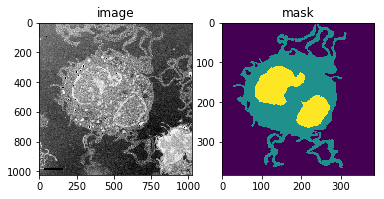

The rescaled image:
torch.Size([3, 388, 388])
torch.float32


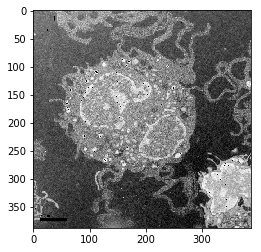

The mask:
torch.uint8


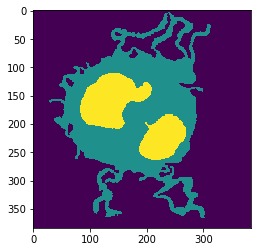

In [11]:
## Test of the transformation
fig = plt.figure()
# Pick a sample
idx = randint(0,42)
sample = train_data[idx]
img = sample['image']
mask = sample['mask']
print(mask.size())
print(img.size())

# original image visualization
print("The original image:")
show_mask(img.permute(1,2,0), mask)

# rescaled image visualization
print("The rescaled image:")
rescaled_image = compose(img)
# After the transform, the img size is 3 x 388 x388, the data range is [-1,1], the datatype is float32
print(rescaled_image.size())
print(rescaled_image.dtype)
rescaled_image = rescaled_image / 2 + 0.5     # unnormalize

plt.imshow(rescaled_image.permute(1,2,0))
plt.pause(0.5)

print('The mask:')
print(mask.dtype)

plt.imshow(mask)

### Define the transformed dataset

In [12]:
transformed_dataset = TrainDataset(img_dir=img_dir, mask_dir = mask_dir, transform = compose)

# Test the transformed dataset, visualization of the dataset
In the transformed dataset, 
* Image data type is `torch.float32`, data range is :[-1,1]
* Mask data type is `torch.int64`, data value is (0,1,2)

Image info:
torch.Size([3, 388, 388])
torch.float32
tensor(1.)
tensor(-1.)

 Mask info:
torch.uint8
torch.Size([384, 384])
tensor(2, dtype=torch.uint8)
tensor(0, dtype=torch.uint8)
<class 'torch.Tensor'>

The image is:


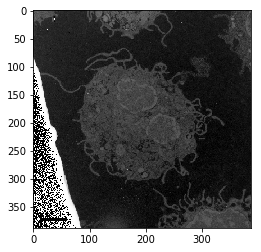

<class 'torch.Tensor'>

The mask is:


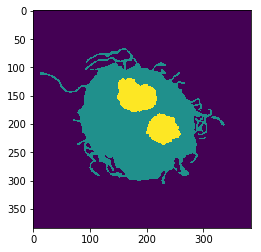

In [13]:
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    img = sample['image']
    mask = sample['mask']
    
    print('Image info:')
    print(img.size())
    print(img.dtype)
    print(torch.max(img))
    print(torch.min(img))
    
    print('\n Mask info:')
    print(mask.dtype)
    print(mask.size())
    print(torch.max(mask))
    print(torch.min(mask))
    print(type(img))
    print('\nThe image is:')
    img = img / 2 + 0.5     # unnormalize
    plt.imshow(img.permute(1,2,0))
    plt.pause(0.5)
    
    print(type(mask))
    print('\nThe mask is:')
    plt.imshow(mask)
    plt.pause(0.5)
    if i == 0:  
        break

### Use the dataloader in Pytorch to form the train dataset
Data loader. Combines a dataset and a sampler, and provides single- or multi-process iterators over the dataset.

In [14]:
dataloader = DataLoader(transformed_dataset, batch_size = 5, shuffle = True, num_workers = 4)

In [15]:
print(len(dataloader))

9


In [16]:
for i_batch, sample_batched in enumerate(dataloader):
    print(sample_batched['image'].size())
    print(sample_batched['mask'].size())
    if i_batch ==0:
        break

torch.Size([5, 3, 388, 388])
torch.Size([5, 384, 384])


### Define the network

In [17]:
class double_conv(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(double_conv, self).__init__()
        
        self.doubleconv = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size = 3, padding =1), #same padding
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.Conv2d(out_channel, out_channel, kernel_size = 3,padding =1), #same padding
            nn.BatchNorm2d(out_channel),
            nn.ReLU()
        )
    def forward(self, x):
        x = self.doubleconv(x)
        return x

#### The down class represent the maxpool layer and the first block, which means the down flow in unet

In [18]:
class down(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(down, self).__init__()
        self.downconv = nn.Sequential(
            nn.MaxPool2d(2, stride = 2),
            double_conv(in_channel, out_channel)
        )
    def forward(self, x):
        x = self.downconv(x)
        return x        

### The up class represent the block in the expansive path

In [19]:
class up(nn.Module):
    def __init__(self,in_channel, out_channel):
        super(up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channel, out_channel, kernel_size = 2, stride = 2)
        self.conv = double_conv(in_channel, out_channel)
    def forward(self, x1, x2):
        # after the convtranspose2d, the output W,H doubled.
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        # crop x2 
        x2 = x2[:,:,diffY//2:diffY//2+x1.size()[2] , diffX//2:diffX//2+x1.size()[3]] 
        x = torch.cat([x2,x1], dim = 1)
        x = self.conv(x)
        return x

#### The final conv layer

In [20]:
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

### Pack all layers together

In [21]:
class UNet(nn.Module):
    """
    Args:
        input channel(int)
        output channel(int)
    """
    def __init__(self):
        super(UNet, self).__init__()
        

        if 2==1:
            self.conv_in = double_conv(3,64)
            self.down1 = down(64,128)
            self.down2 = down(128,256)
            self.down3 = down(256,512)
            self.down4 = down(512,1024)

            self.up1 = up(1024,512)
            self.up2 = up(512,256)
            self.up3 = up(256,128)
            self.up4 = up(128,64)
            

            self.conv_out = outconv(64,3)
        
        
        
        self.conv_in = double_conv(3,8)
        self.down1 = down(8,16)
        self.down2 = down(16,32)
        self.down3 = down(32,64)
        self.down4 = down(64,128)
        
        self.up1 = up(128,64)
        self.up2 = up(64,32)
        self.up3 = up(32,16)
        self.up4 = up(16,8)
        self.conv_out = outconv(8,3)
        
       

    def forward(self, x):
        x1 = self.conv_in(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.conv_out(x)
        x = F.log_softmax(x, dim =1)
        return x

### Unet parameters

In [22]:
# input channel is 3, output channel is 1
unet = UNet()
print(unet)
unet_params = list(unet.parameters())
print("The length of the unet parameter is: ")
print(len(unet_params))
print("The conv1's weight: ")
print(unet_params[0].size()) # conv1's weight  0.4.
print("The weight's dtype: ")
print(unet_params[0].dtype)

nb_param=0
for param in unet.parameters():
    nb_param+=np.prod(list(param.data.size()))
print(nb_param)

UNet(
  (conv_in): double_conv(
    (doubleconv): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down1): down(
    (downconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (doubleconv): Sequential(
          (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


#### Test the Unet

In [23]:
bs=1
x=torch.rand(bs,3,388,388)
y = unet(x)
print(y.size())

torch.Size([1, 3, 384, 384])


### Make sure the current device 

In [24]:
current_device = torch.cuda.current_device()
torch.cuda.device(current_device)

In [25]:
torch.cuda.device_count()

1

In [26]:
torch.cuda.get_device_name(0)

'GeForce GTX 1080 Ti'

In [27]:
unet = unet.to(device)

In [28]:
print(unet_params[0].dtype)

torch.float32


### Define the loss function and learning rate

In [29]:
criterion = nn.NLLLoss()

In [30]:
def get_error( scores , labels ):

    bs=scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_matches=indicator.sum()
    
    return 1-num_matches.float()/bs    

#### Inputs size: bs x 3 x 572 x 572 tensor, which is in range [-1,1], data type is float32
#### Labels size: bs x 572 x 572 tensor, the values is 0.3333, 0.6667, 0.1, data type is float32

In [31]:
optimizer = optim.Adam(unet.parameters() ,lr=0.001)


start=time.time()
for epoch in range(1,500):
   
    

    # define the running loss
    running_loss = 0
    running_error = 0
    num_batches=0
      
    for i_batch, sample_batched in enumerate(dataloader):
        
        optimizer.zero_grad()
        
        #get the inputs
        inputs, labels = sample_batched['image'], sample_batched['mask']
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        inputs.requires_grad_()
        
        #forward + backward +optimize
        scores = unet(inputs)
      

        # Define the loss
        loss = criterion(scores, labels.long()) 
        loss.backward()
        optimizer.step()
        
        # compute and accumulate stats
        running_loss += loss.detach().item()
       
        num_batches+=1 
    
    # AVERAGE STATS THEN DISPLAY    
    total_loss = running_loss/num_batches
   
    elapsed = (time.time()-start)/60
        
    print('epoch=',epoch, '\t time=', elapsed,'min', '\t loss=', total_loss )

       
print('Finish Training')

epoch= 1 	 time= 0.01749186118443807 min 	 loss= 1.2634840938780043
epoch= 2 	 time= 0.033037455876668294 min 	 loss= 1.1910247537824843
epoch= 3 	 time= 0.048282365004221596 min 	 loss= 1.1414984862009685
epoch= 4 	 time= 0.06340322494506836 min 	 loss= 1.1019570032755535
epoch= 5 	 time= 0.07879122495651245 min 	 loss= 1.0675892962349787
epoch= 6 	 time= 0.09449196259180705 min 	 loss= 1.0302323632770114
epoch= 7 	 time= 0.1101020375887553 min 	 loss= 0.989467097653283
epoch= 8 	 time= 0.1258351445198059 min 	 loss= 0.9524960186746385
epoch= 9 	 time= 0.14005561272303263 min 	 loss= 0.9122322930230035
epoch= 10 	 time= 0.15571356217066448 min 	 loss= 0.8835719227790833
epoch= 11 	 time= 0.1707974672317505 min 	 loss= 0.8346568809615241
epoch= 12 	 time= 0.18562021255493164 min 	 loss= 0.8079113827811347
epoch= 13 	 time= 0.2004813075065613 min 	 loss= 0.766134606467353
epoch= 14 	 time= 0.2164631724357605 min 	 loss= 0.7263559103012085
epoch= 15 	 time= 0.23252606391906738 min 	 loss

epoch= 121 	 time= 1.8269158840179442 min 	 loss= 0.10733260131544536
epoch= 122 	 time= 1.842387616634369 min 	 loss= 0.10353864563835992
epoch= 123 	 time= 1.8568911830584207 min 	 loss= 0.10837464531262715
epoch= 124 	 time= 1.8717284321784973 min 	 loss= 0.10331902818547355
epoch= 125 	 time= 1.8871878345807394 min 	 loss= 0.10274212559064229
epoch= 126 	 time= 1.9021602630615235 min 	 loss= 0.09874462501870261
epoch= 127 	 time= 1.9173101703325908 min 	 loss= 0.1030241350332896
epoch= 128 	 time= 1.9327497323354086 min 	 loss= 0.12703226837846968
epoch= 129 	 time= 1.946868634223938 min 	 loss= 0.12398600081602733
epoch= 130 	 time= 1.9617781201998392 min 	 loss= 0.12384026414818233
epoch= 131 	 time= 1.9759553352991739 min 	 loss= 0.10548286388317744
epoch= 132 	 time= 1.9899833043416342 min 	 loss= 0.09924681567483479
epoch= 133 	 time= 2.0055792689323426 min 	 loss= 0.10256414777702755
epoch= 134 	 time= 2.021070210138957 min 	 loss= 0.10894937647713555
epoch= 135 	 time= 2.035

epoch= 240 	 time= 3.6239851911862693 min 	 loss= 0.07058519663082229
epoch= 241 	 time= 3.6401580333709718 min 	 loss= 0.06738796126511362
epoch= 242 	 time= 3.6551107088724772 min 	 loss= 0.05928622144791815
epoch= 243 	 time= 3.670080534617106 min 	 loss= 0.05125002107686467
epoch= 244 	 time= 3.6854833126068116 min 	 loss= 0.04596345374981562
epoch= 245 	 time= 3.700251046816508 min 	 loss= 0.04364797141816881
epoch= 246 	 time= 3.71499795516332 min 	 loss= 0.04182272921833727
epoch= 247 	 time= 3.7297744154930115 min 	 loss= 0.0417740179432763
epoch= 248 	 time= 3.7447802503903707 min 	 loss= 0.04405865901046329
epoch= 249 	 time= 3.7588602542877196 min 	 loss= 0.046359237697389394
epoch= 250 	 time= 3.7726118167241416 min 	 loss= 0.043076925807529025
epoch= 251 	 time= 3.788475227355957 min 	 loss= 0.04182867002156046
epoch= 252 	 time= 3.802844587961833 min 	 loss= 0.04009039286110136
epoch= 253 	 time= 3.81804651816686 min 	 loss= 0.03796254760689206
epoch= 254 	 time= 3.833272

epoch= 358 	 time= 5.401022569338481 min 	 loss= 0.027573984530236986
epoch= 359 	 time= 5.416047183672587 min 	 loss= 0.02677299930817551
epoch= 360 	 time= 5.430978524684906 min 	 loss= 0.027053434608711138
epoch= 361 	 time= 5.446000142892202 min 	 loss= 0.025463648761312168
epoch= 362 	 time= 5.461001201470693 min 	 loss= 0.024894332099292014
epoch= 363 	 time= 5.475421619415283 min 	 loss= 0.023998672556546
epoch= 364 	 time= 5.490066599845886 min 	 loss= 0.02443010484178861
epoch= 365 	 time= 5.504328914483389 min 	 loss= 0.025213374238875177
epoch= 366 	 time= 5.519705935319265 min 	 loss= 0.031581354017059006
epoch= 367 	 time= 5.534562742710113 min 	 loss= 0.061862748116254807
epoch= 368 	 time= 5.5502119620641075 min 	 loss= 0.09849098904265298
epoch= 369 	 time= 5.565965485572815 min 	 loss= 0.0764767937362194
epoch= 370 	 time= 5.5804388403892515 min 	 loss= 0.0797069515619013
epoch= 371 	 time= 5.596086839834849 min 	 loss= 0.0768689430422253
epoch= 372 	 time= 5.611430895

epoch= 476 	 time= 7.183799568812052 min 	 loss= 0.019789218695627317
epoch= 477 	 time= 7.1987091422080995 min 	 loss= 0.01968857128587034
epoch= 478 	 time= 7.214216113090515 min 	 loss= 0.019382876654465992
epoch= 479 	 time= 7.229003326098124 min 	 loss= 0.01932807235668103
epoch= 480 	 time= 7.243383105595907 min 	 loss= 0.01859818771481514
epoch= 481 	 time= 7.257683134078979 min 	 loss= 0.019662126898765564
epoch= 482 	 time= 7.273522035280863 min 	 loss= 0.019391175359487534
epoch= 483 	 time= 7.288040935993195 min 	 loss= 0.019230497173137136
epoch= 484 	 time= 7.303398633003235 min 	 loss= 0.019934997376468446
epoch= 485 	 time= 7.317414764563242 min 	 loss= 0.019490913384490542
epoch= 486 	 time= 7.333550047874451 min 	 loss= 0.01812006760802534
epoch= 487 	 time= 7.3491494735081995 min 	 loss= 0.018252200136582058
epoch= 488 	 time= 7.364517450332642 min 	 loss= 0.01801059777951903
epoch= 489 	 time= 7.37994845310847 min 	 loss= 0.01768691682567199
epoch= 490 	 time= 7.3942

#### Choose image at random from the test set and see how good/bad are the predictions

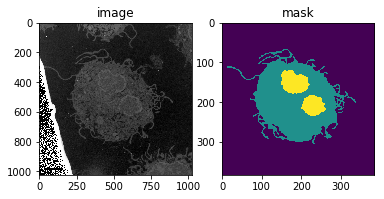

torch.Size([384, 384, 3])
tensor(1.)
tensor(3.8357e-08)


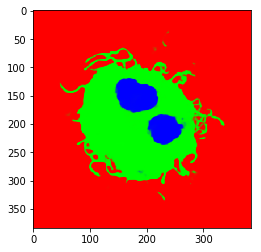

In [32]:
sample=train_data[0]
img = sample['image']
mask = sample['mask']

show_mask(img.permute(1,2,0), mask)

compose = transforms.Compose([transforms.ToPILImage(),transforms.Resize((388,388)),
                              transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

img = compose(img)

img = img.unsqueeze(dim = 0)
img = img.to(device)

# feed it to network
scores =  unet(img)
scores = scores.detach().cpu().squeeze().permute(1,2,0)
print(scores.size())
print(torch.max(torch.exp(scores)))
print(torch.min(torch.exp(scores)))
plt.imshow(torch.exp(scores))

scores = scores.detach().cpu().squeeze()

a = torch.tensor(0.)

idx = torch.Tensor([[]])

# for i in range(scores.size(1)):
#     for j in range(scores.size(2)):
#         pixel = scores[:,i,j]
#         for k in range(3):
#             if(pixel[k]>a):
#                 a = pixel[k]
#                 idx = k
        


In [33]:
# out_put = torch.Tensor([])
# mapp = {
#         0 : torch.Tensor([255, 255, 255]),
#         1 : torch.Tensor([255, 0, 0]),
#         2 : torch.Tensor([0, 255, 0])
#        }
# output = torch.Tensor([0,1,0,2])

# for i in output:
#     print(mapp[np.uint(i.numpy())])
#     out_put = torch.cat((out_put,mapp[np.uint(i.numpy())].unsqueeze(dim = 0)))
# print(out_put)